### Importing the libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import warnings
from itertools import combinations
import xgboost as xg
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from scipy import stats
import time
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)



### Reading the Datasets

Simply read CSV files and store them in Pandas dataframes, `df` and `df_EVAL`, for the development and evaluation files, respectively. Additionally, store the (x,y) coordinates in `target`.

In [2]:
df = pd.read_csv("development.csv")
df_EVAL = pd.read_csv('evaluation.csv')
target = df.iloc[:, 0:2]
df = df.iloc[:,2:] 

# Preprcessing (Detecting Noise Columns)

### 1. Statistical Appraoch 

#### 1.1 Displaying Non-Linearity

 **NOTE: ```df.sample(frac=1, random_state=1)``` is used as plotting the scatter for the whole dataframe will take about 4 min. If you wish to run a faster plot, you can change the argument `frac` to 0.5 or 0.3.**
 
 This peice of code plots the scatter plot for the whole dataset to show the non-linearity of the relationship between (x,y) and the one attribute 'pmax'. ```features = [f'{prop}[{i}]' for prop in properties for i in range(8)]``` simply creates an array of the coulmn names we're trying to fetch, pmax[i], i ranging from 0 to 7. The `enumerate()` function in Python adds a counter to an iterable and returns it as an enumerate object. `axs` is a 2D array of axes objects, creating a grid of plots with 2 rows and 4 columns. `row = i // 4` is using integer division (//) to determine the row index; it returns the largest whole number less than or equal to the division. So for i values of 0, 1, 2, and 3, row will be 0. For i values of 4, 5, 6, and 7, row will be 1. `col = i % 4`: use the modulus operator (%) to determine the column index, which returns the remainder of the division. So for i values of 0, 4, 8, etc., col will be 0. For i values of 1, 5, 9, etc., col will be 1, and so on. This effectively cycles the col value through 0 to 3 for each row.

 



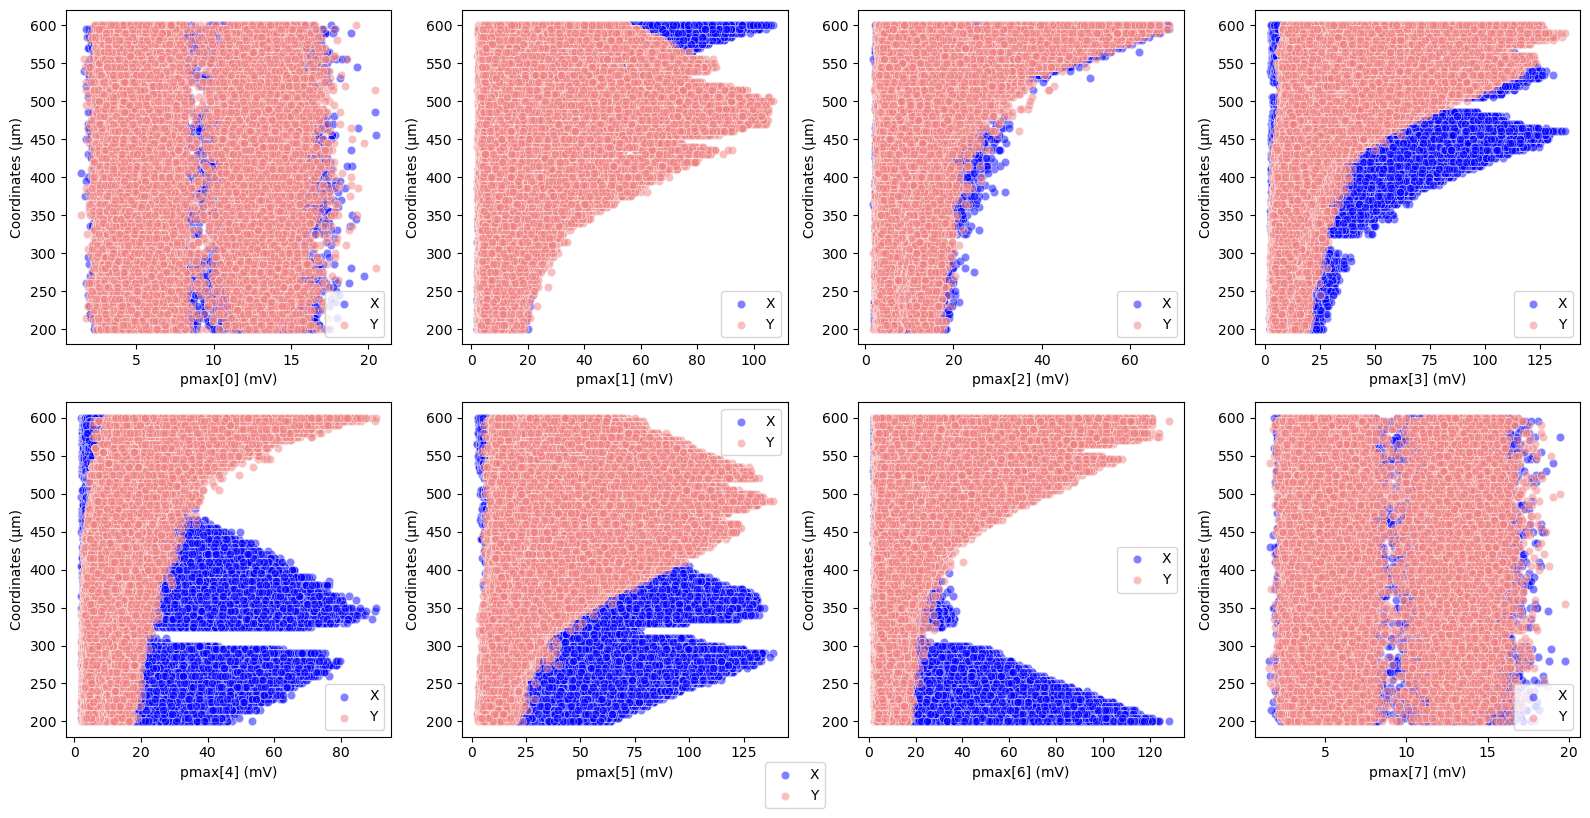

In [3]:
df_sampled = df.sample(frac=1, random_state=1)
target_sampled = target.sample(frac=1, random_state=1)

properties = ['pmax']
features = [f'{prop}[{i}]' for prop in properties for i in range(8)]
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i, feature in enumerate(features):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    sns.scatterplot(x=df_sampled[feature], y=target_sampled.iloc[:, 0], label='X', alpha=0.5, color='blue', ax=ax)
    
    sns.scatterplot(x=df_sampled[feature], y=target_sampled.iloc[:, 1], label='Y', alpha=0.5, color='lightCoral', ax=ax)
    
    ax.set_xlabel(feature+" (mV)")
    ax.set_ylabel("Coordinates (μm)")
    
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.025))
plt.tight_layout()

#plt.savefig('SCAT223.png',format='png', bbox_inches='tight')

plt.show()


#### 1.2 Calculating Spearman Correlation

This piece of code calculates the Spearman correlation for the columns `pmax`,`tmax`,`area` for all the 18 readings. If the correlation for either X or Y, is less than 0.05, it will store the name of the column and the corresponding correlations in an array: ```            x[p][f"{p}[{i}]"]=[corr_x,corr_y]``` 

In [4]:
properties = ['pmax','tmax','area']
x = {}
x['pmax']={}
x['tmax']={}
x['area']={}
for p in properties:
    for i in range(18):
        corr_x = df[f"{p}[{i}]"].corr(target['x'],method="pearson")
        corr_y = df[f"{p}[{i}]"].corr(target['y'],method="pearson")
        if(np.abs(corr_x)<0.05 or np.abs(corr_y)<0.05):
            x[p][f"{p}[{i}]"]=[corr_x,corr_y]

print(x['pmax'])
print(x['tmax'])
print(x['area'])

{'pmax[0]': [-0.0036474887621560565, 0.013364566382587229], 'pmax[7]': [-0.006498066054161933, 0.015403919487645294], 'pmax[12]': [0.0019261768215859372, 0.00177442445058969], 'pmax[15]': [0.010713971565644178, -0.3302744387375665], 'pmax[16]': [0.012064236535658936, 0.0035572178951813623], 'pmax[17]': [0.014024924095635757, -0.002007775633016432]}
{'tmax[0]': [-0.0005747495556624141, 0.0008478060449935991], 'tmax[7]': [0.0005632454452733278, -0.0025845060744225054], 'tmax[8]': [0.2165449650779944, 0.0016152874725729924], 'tmax[12]': [-0.0024304408614519647, 0.0014453286278587696], 'tmax[13]': [-0.06093931460510444, 0.014332206383207058], 'tmax[15]': [0.001373951251651819, 0.09323723546436821], 'tmax[16]': [0.000835383637047391, 0.0014573773503520902], 'tmax[17]': [0.001113016556997174, 0.0012103330977689855]}
{'area[0]': [-0.001607299979364324, 0.0020799706123681263], 'area[7]': [-0.0026966120935442684, 0.0019790571600240246], 'area[12]': [0.000976133631421979, -0.0005710818437288859]

### 2. Visualization Approach

This piece of code plots a historam for `pmax`, `tmax`, `area` of each readings. The reason why we enumerated indices and properties was that we want the plots to be ordered of pmax[i],tmax[i], and area[i]. otherwise we would have simply looped over df.columns.
Also, we set a different color to the column noises to stand out.
Additionally, the units were defined for each property. 

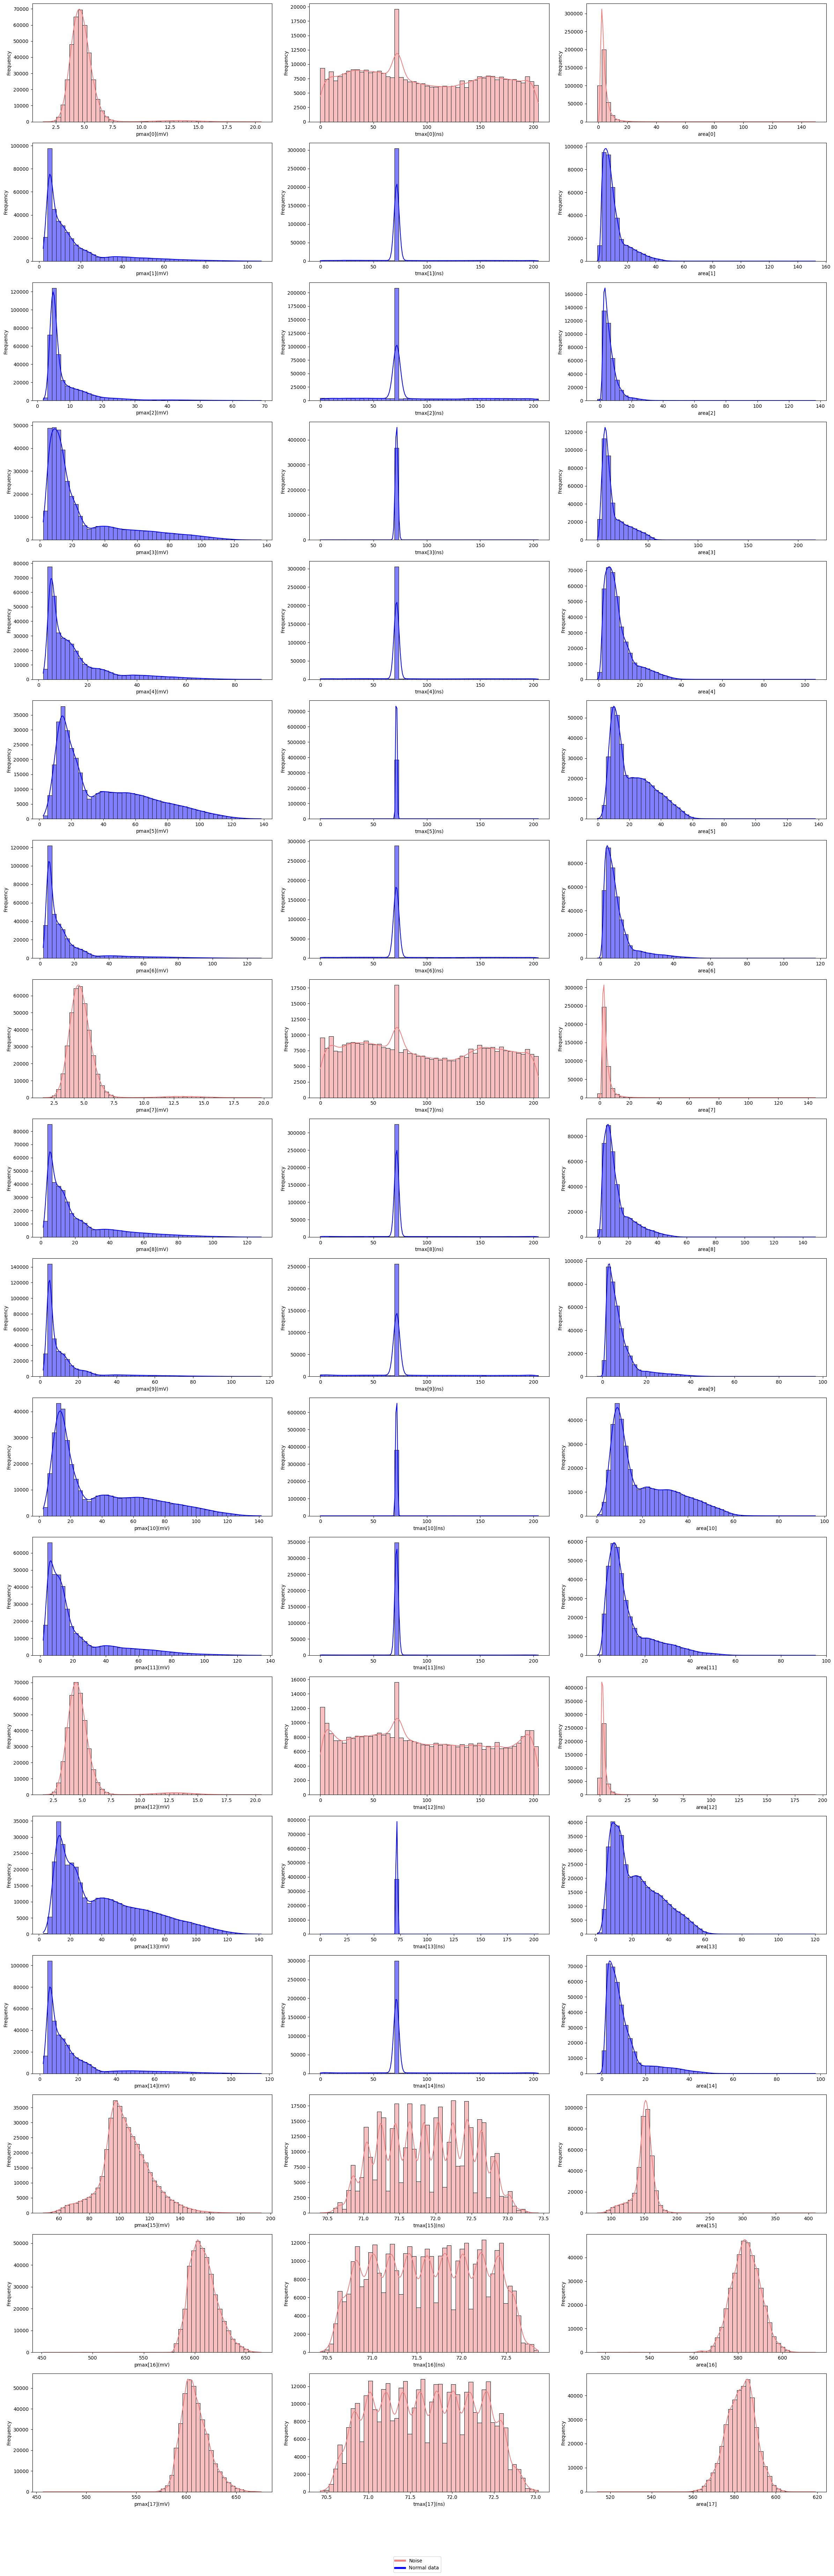

In [30]:
properties = ['pmax', 'tmax', 'area']
indices = range(18)
colors = {index: 'lightCoral' if index in [0, 7, 12, 15, 16, 17] else 'blue' for index in indices}
units = {'pmax': '(mV)', 'tmax': '(ns)', 'area': ''}

fig, axs = plt.subplots(18, 3, figsize=(24, 72))  
for i, index in enumerate(indices):
    for j, prop in enumerate(properties):
        feature = f'{prop}[{index}]'
        row = i
        col = j
        ax = axs[row, col]
        color = colors[index]
        sns.histplot(df[feature], bins=50, color=color, ax=ax, kde=True)
        ax.set_xlabel(feature + units[prop] )
        ax.set_ylabel("Frequency")

handles = [plt.Line2D([0], [0], color='lightCoral', lw=4),
           plt.Line2D([0], [0], color='blue', lw=4)]
labels = ['Noise', 'Normal data']

fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.025))
plt.tight_layout()
#plt.savefig('Dis3.pdf', dpi=300, bbox_inches='tight')  # Add bbox_inches='tight'
plt.show()


### 3.Brute Force Approach

First we need to define average_eculidean_distance, the metric. 

In [33]:
def average_euclidean_distance(y,y_predict):
    distances = np.sqrt(np.sum((y - y_predict)**2, axis=1))
    return np.mean(distances)

Using `Combination ()` function, we generate all possible 6-item combinations of the numbers from 0 to 17. Then one by one, we drop the radings of one combination, calculate the euclidean distance for it and move on to the next combination. At the end, ```min(results, key=results.get)``` will output the best result and the combination. 

**ATTEMTION: Running this code can be computationally expensive and will take hours to run.**

In [35]:
"""
parametri_regressor = {
   'colsample_bytree': 0.70,
    'colsample_bylevel': 0.8,
    'colsample_bynode': 0.8,
    'max_depth': 15,
    'min_child_weight': 1,
    'reg_alpha': 1,
    'reg_lambda': 0.01
}

pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', xg.XGBRegressor(tree_method= 'hist', booster='gbtree', device='cuda', eta=0.1, gamma=33, **parametri_regressor, n_jobs=-1, random_state=42, verbosity=0, objective='reg:squarederror'))
])


combos = list(combinations(range(18), 6))
results = {} # Initialize a dictionary to store the results

X = df
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for combo in combos:
    columns_to_drop = [f'{prop}[{i}]' for prop in ['pmax', 'tmax', 'area', 'negpmax', 'rms'] for i in combo]
    X_train_dropped = X_train.drop(columns_to_drop, axis=1)
    X_test_dropped = X_test.drop(columns_to_drop, axis=1)
    
    pipe_rf.fit(X_train_dropped, y_train)
    predictions = pipe_rf.predict(X_test_dropped)
    aed = average_euclidean_distance(y_test, predictions)
    results[tuple(combo)] = aed  # Convert combo to a tuple

best_combo = min(results, key=results.get)
print(f"Best combination: {best_combo}, Average Euclidean Distance: {results[best_combo]}") 

"""



Best combination: (0, 7, 12, 15, 16, 17), Average Euclidean Distance: 4.3599975166724


### 4. Removing Noise Columns 

In [3]:
properties = ['pmax', 'negpmax', 'area', 'tmax','rms']
cols_to_be_removed = [f'{prop}[{i}]' for prop in properties for i in [0,7,12,15,16,17]]
df.drop(cols_to_be_removed,axis=1,inplace=True)
df_EVAL.drop(cols_to_be_removed,axis=1,inplace=True)

# Model 

We followed the same procedure for training our regressor as we would for a traditional sklearn model. We employed both the train-test-split method (commented) and trained the model on the entire dataset for evaluation purposes.

**IMPRTANT NOTE:    
 To expedite model execution, we set the default value of `num_parallel_tree` to 1. This can be adjusted (we tested values from 1 to 16) at the expense of increased execution time.**
 
 When using train-test-split, both R^2 and MSE metrics can be obtained. Additionally, we imported the time library to measure code execution time.

In [21]:
start = time.time()
parametri_regressor = {
    'colsample_bytree': 0.70, 
    'colsample_bylevel': 0.8,
    'colsample_bynode': 0.8,
    'max_depth': 15,
    'min_child_weight': 10,
    'reg_alpha': 1,
    'reg_lambda': 0.01,
    'num_parallel_tree': 1
}
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', xg.XGBRegressor(n_estimators=1000,tree_method= 'hist', booster='gbtree', device='cuda', eta=0.06, gamma=4, **parametri_regressor, n_jobs=-1, random_state=42, verbosity=0, objective='reg:squarederror'))
])
X = df
y = target

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

pipe_rf.fit(X, y)

# y_pred_rf = pipe_rf.predict(X_test)

# mse_rf = mean_squared_error(y_test, y_pred_rf)
# print(f'Mean Squared Error: {mse_rf}')

# r2 = r2_score(y_test, y_pred_rf)
# print(f'R-squared Score: {r2}')

end = time.time()

print("Time: ",end-start)

Time:  128.76597809791565


The following code can be used to generate a file to upload to the evaluation platform:

In [22]:
X_eval = df_EVAL.iloc[:,1:].values

y_eval_pred = pipe_rf.predict(X_eval)

dc = pd.DataFrame(y_eval_pred, columns=['X', 'Y'])

dc['Id'] = range(len(dc))

dc['Predicted'] = dc[['X', 'Y']].astype(str).agg('|'.join, axis=1)

result_dc = dc[['Id', 'Predicted']]

result_dc.to_csv('outputX.csv', index=False)

# HyperParameter Tuning

As mentioned in our  report, this code took over two hours to execute. We are now providing the commented code for your reference.

In [ ]:
# import xgboost as xg
# from sklearn.metrics import r2_score
# import time
# start = time.time()
# df_sample = df.sample(frac=1/100, random_state=42)
# target_sample = target.sample(frac=1/100, random_state=42)
# param_grid = {
#     'regressor__eta': [0.1,1],
#     'regressor__gamma': [4,5],
#     'regressor__max_depth' : [10, 15],
#     'regressor__colsample_bytree' : [0.5, 0.7, 1],
#     'regressor__colsample_bylevel' : [0.5, 0.8],
#     'regressor__colsample_bynode' : [0.5, 0.8],
#     'regressor__alpha': [0, 0.5, 1],
#     'regressor__lambda' : [0.01, 0.1],
#     'minchildweight' : 1.10 ,
#     'eta' :0.06
    
# }
# parametri_regressor = {
#     'min_child_weight': 1,
#     'num_parallel_tree': 1
# }

# pipe_rf = Pipeline([
#     ('scaler', StandardScaler()),
#     ('regressor', xg.XGBRegressor(tree_method= 'hist', booster='gbtree', device='cuda', **parametri_regressor, n_jobs=-1, random_state=42, verbosity=0, objective='reg:squarederror'))
# ])

# X = df_sample
# y = target_sample

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


# grid_search = GridSearchCV(pipe_rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose = 2)
# grid_search.fit(X_train, y_train)


# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_


# print("Best Parameters:", best_params)


# y_pred_best = best_model.predict(X_test)

# mse_best = mean_squared_error(y_test, y_pred_best)
# print(f'Mean Squared Error with Best Model: {mse_best}')

# r2_best = r2_score(y_test, y_pred_best)
# print(f'R-squared Score with Best Model: {r2_best}')

# end = time.time()
# print("Time: ", end - start)